# Acheiving 99.4% accuracy in MNIST in a resource constrained system
---

## Constraints:
- Parameters should be less than 20,000
- Accuracy to be achieved in less than 20 epochs
- Fully connected layers must no be used

## How did we achieve it
- We started with a plain network with a minimal network that achieved 98.84% accuracy
- After adding 1x1 convolution just before max pooling, the accuracy increased to 99.09%
- Adding batch normalization after every concolution, increased the accuracy to 99.37%
- All the above network had parameters ~12.5k
- After a bit of experimentation, increasing the parameters to ~17.5k did the trick and achieved 99.42% max accuracy
- However, it was just one epoch, while most of the epochs were just below 99.4%
- We therefore decided to experiment a little more and added another layer to the original layer with ~12.5k params and added a GAP layer at the end. Params decreased to ~8.5k since convolution in the penultimate layer went down from 6x6 kernel to 3x3 kernel
- This gave us 99.35% accuracy. 
- Encouraged by the leeway we had in terms of increasing parameters, we increased kernels in two of the middle layers from 16 to 32 and voila! We got a max accuracy of 99.59% with this model!

## The model that gave the accuracy consists of:
- Contains 8 layers with following number of kernels:
  - Conv 8 -> Conv 8 -> Bottlenck -> Conv 32 -> Conv 32 -> Conv 16 -> Conv 16 -> GAP
  - Bottleneck layer = Maxpool + 1x1 Conv
- Only 3x3 convolution used everywhere (except for the bottleneck & GAP layers
- Except the bottleneck & last Conv layer, every convolution is followed by "RELU" & "Batch Normalization"
- No padding has been used anywhere

## Details of experimentation
### Successful experiments:  
  
Manual Search Path | Model Id | Model Desc | Optimizer | Epochs | Params | Train Time | Last 10 Epoch Avg Acc | Last 5 Epoch Avg Acc | Max Acc | 
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
  -> 0 | 0 | 3-8, 3-8, MP, 3-16, 3-16, 3-16, 6-10 | SGD, lr=0.01, momentum=0.9) | 20 |  | 283.06 | 0.98711 | 0.98674 | 0.9884 | 
0 -> 1 | 1 | 3-8, 3-8, MP, 1x1, 3-16, 3-16, 3-16, 6-10 | SGD, lr=0.01, momentum=0.9) | 20 |  | 289.01 | 0.99024 | 0.99046 | 0.9909 | 
1 -> 2 | 2 | Above network + Batch Norm (after every Relu) | SGD, lr=0.01, momentum=0.9) | 20 | 12442 | 287.77 | 0.99247 | 0.99308 | 0.9937 | 
2 -> 2D | 2D | one more layer + GAP | SGD, lr=0.01, momentum=0.9) | 20 | 8142 | 503.51 | 0.99259 | 0.99308 | 0.9935 | 
2D -> 2Da | 2Da | increased kernels from 16 to 32 in 2 of the middle layers | SGD, lr=0.01, momentum=0.9) | 20 | 18606 | 515.72 | 0.99469 | 0.99466 | 0.9959 |  
  
  ---
### Failed Experiments - 1:  
Manual Search Path | Model Id | Model Desc | Optimizer | Epochs | Params | Train Time | Last 10 Epoch Avg Acc | Last 5 Epoch Avg Acc | Max Acc | 
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
2 -> 2B | 2B | Above network + Drouput after 1st layer (@ 20%) | SGD, lr=0.01, momentum=0.9) | 20 | 12442 | 262.65 | 0.99295 | 0.99314 | 0.9936 | 
2B -> 2Ba | 2Ba | Above network + Drouput after 2 layers (@ 20%) | SGD, lr=0.01, momentum=0.9) | 20 | 12442 | 287.97 | 0.99085 | 0.99098 | 0.9919 | 
2Ba -> 2Bb | 2Bb | Above Network - Dropout 10% instead of 20% | SGD, lr=0.01, momentum=0.9) | 20 | 12442 | 295.9 | 0.99286 | 0.99318 | 0.9937 | 
2Bb -> 2Bc | 2Bc | Above Network + Dropout added to all layers | SGD, lr=0.01, momentum=0.9) | 20 | 12442 | 296.06 | 0.99239 | 0.99278 | 0.9933 |  
  
  ---
### Failed Experiments - 2:  
Manual Search Path | Model Id | Model Desc | Optimizer | Epochs | Params | Train Time | Last 10 Epoch Avg Acc | Last 5 Epoch Avg Acc | Max Acc | 
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
2 -> 2C | 2C | Above Network + increased all 8s to 12 & 16s to 20 | SGD, lr=0.01, momentum=0.9) | 20 | 17902 | 292.13 | 0.99326 | 0.993719 | 0.9942 | 

---

## SCRIPT SECTION
---

### Setup Google Drive for saving / reloading previous saved values

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

base_folder = 'drive/My Drive/eva_stored_from_colab/eva5/'
acc_recorder_file = "highest_accuracy_achieved"
model_file_name = "final_model"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import required modules

In [ ]:
from __future__ import print_function
from operator import itemgetter
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### The Network Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.bn2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.antman = nn.Conv2d(8, 8, 1)
        self.conv3 = nn.Conv2d(8, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 16, 3)
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 10, 3)
        self.bn6 = nn.BatchNorm2d(10)
        self.gap = nn.AvgPool2d(4)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.antman(self.pool1(x))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.gap(self.bn6(self.conv6(x)))
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

### Calculating total parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3            [-1, 8, 24, 24]             584
       BatchNorm2d-4            [-1, 8, 24, 24]              16
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]              72
            Conv2d-7           [-1, 32, 10, 10]           2,336
       BatchNorm2d-8           [-1, 32, 10, 10]              64
            Conv2d-9             [-1, 32, 8, 8]           9,248
      BatchNorm2d-10             [-1, 32, 8, 8]              64
           Conv2d-11             [-1, 16, 6, 6]           4,624
      BatchNorm2d-12             [-1, 16, 6, 6]              32
           Conv2d-13             [-1, 10, 4, 4]           1,450
      BatchNorm2d-14             [-1, 1

### Downloading the MNIST dataset

In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


### Defining train & test functions

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    
    total_imgs = len(train_loader.dataset)
    train_loss /= total_imgs
    accuracy = 100. * correct / total_imgs

    print('\nTrain Data: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        train_loss, correct, total_imgs, accuracy)
    )
    
    return train_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

def record_max_acc(max_acc):
    f = open(base_folder+acc_recorder_file, "w")
    f.write(str(max_acc))
    f.close()

### Training for 20 epochs

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

start = time.time()
test_acc = []
train_acc = []

try:
    with open(base_folder+acc_recorder_file, "r") as infl:
        max_acc = float(infl.read().strip())
except:
    max_acc = 0.0

print("\nLAST RECORDED MAX ACCURACY: ", max_acc)
for epoch in range(1, 21):
    ep_start = time.time()
    print()
    print("EPOCH NUM {}".format(epoch))
    trl, tra = train(model, device, train_loader, optimizer, epoch)
    tsl, tsa = test(model, device, test_loader)
    test_acc.append(tsa)
    train_acc.append(tra)
    if tsa > max_acc:
        max_acc = tsa
        torch.save(model.state_dict(), base_folder+model_file_name+"_sd.pth")
        record_max_acc(max_acc)
    print("-----------------------------------------------")
print("TOTAL TRAINING TIME: ", time.time() - start)
print("LAST 10 EPOCH AVG ACC: ", sum(test_acc[-10:]) / len(test_acc[-10:]) )
print("LAST 5 EPOCH AVG ACC: ", sum(test_acc[-5:]) / len(test_acc[-5:]) )
print("MAX ACCURACY: ", max(test_acc))

  0%|          | 0/469 [00:00<?, ?it/s]


LAST RECORDED MAX ACCURACY:  0.9942

EPOCH NUM 1


loss=0.10131686925888062 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]


Train Data: Average loss: 0.0022, Accuracy: 57338/60000 (95.5633%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9868/10000 (98.6800%)

-----------------------------------------------

EPOCH NUM 2


loss=0.08053163439035416 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]


Train Data: Average loss: 0.0006, Accuracy: 59128/60000 (98.5467%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9915/10000 (99.1500%)

-----------------------------------------------

EPOCH NUM 3


loss=0.03805229440331459 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.38it/s]


Train Data: Average loss: 0.0004, Accuracy: 59339/60000 (98.8983%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9923/10000 (99.2300%)

-----------------------------------------------

EPOCH NUM 4


loss=0.06814157962799072 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]


Train Data: Average loss: 0.0003, Accuracy: 59471/60000 (99.1183%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9921/10000 (99.2100%)

-----------------------------------------------

EPOCH NUM 5


loss=0.07435036450624466 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]


Train Data: Average loss: 0.0003, Accuracy: 59511/60000 (99.1850%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9929/10000 (99.2900%)

-----------------------------------------------

EPOCH NUM 6


loss=0.07247842848300934 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]


Train Data: Average loss: 0.0003, Accuracy: 59565/60000 (99.2750%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9924/10000 (99.2400%)

-----------------------------------------------

EPOCH NUM 7


loss=0.01244586706161499 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]


Train Data: Average loss: 0.0002, Accuracy: 59601/60000 (99.3350%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9930/10000 (99.3000%)

-----------------------------------------------

EPOCH NUM 8


loss=0.02379949390888214 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]


Train Data: Average loss: 0.0002, Accuracy: 59650/60000 (99.4167%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9921/10000 (99.2100%)

-----------------------------------------------

EPOCH NUM 9


loss=0.05103449523448944 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]


Train Data: Average loss: 0.0002, Accuracy: 59687/60000 (99.4783%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9954/10000 (99.5400%)

-----------------------------------------------

EPOCH NUM 10


loss=0.009501234628260136 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.31it/s]


Train Data: Average loss: 0.0002, Accuracy: 59706/60000 (99.5100%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9945/10000 (99.4500%)

-----------------------------------------------

EPOCH NUM 11


loss=0.015302632935345173 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]


Train Data: Average loss: 0.0002, Accuracy: 59744/60000 (99.5733%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9945/10000 (99.4500%)

-----------------------------------------------

EPOCH NUM 12


loss=0.016498157754540443 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.23it/s]


Train Data: Average loss: 0.0001, Accuracy: 59754/60000 (99.5900%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9941/10000 (99.4100%)

-----------------------------------------------

EPOCH NUM 13


loss=0.00592884561046958 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]


Train Data: Average loss: 0.0001, Accuracy: 59786/60000 (99.6433%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9946/10000 (99.4600%)

-----------------------------------------------

EPOCH NUM 14


loss=0.004116810858249664 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s]


Train Data: Average loss: 0.0001, Accuracy: 59795/60000 (99.6583%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9945/10000 (99.4500%)

-----------------------------------------------

EPOCH NUM 15


loss=0.005989274010062218 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.28it/s]


Train Data: Average loss: 0.0001, Accuracy: 59797/60000 (99.6617%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9959/10000 (99.5900%)

-----------------------------------------------

EPOCH NUM 16


loss=0.007384110242128372 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.23it/s]


Train Data: Average loss: 0.0001, Accuracy: 59845/60000 (99.7417%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9948/10000 (99.4800%)

-----------------------------------------------

EPOCH NUM 17


loss=0.03211048245429993 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]


Train Data: Average loss: 0.0001, Accuracy: 59840/60000 (99.7333%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9950/10000 (99.5000%)

-----------------------------------------------

EPOCH NUM 18


loss=0.036570955067873 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]


Train Data: Average loss: 0.0001, Accuracy: 59838/60000 (99.7300%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9944/10000 (99.4400%)

-----------------------------------------------

EPOCH NUM 19


loss=0.00985632836818695 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]


Train Data: Average loss: 0.0001, Accuracy: 59852/60000 (99.7533%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.4300%)

-----------------------------------------------

EPOCH NUM 20


loss=0.018476512283086777 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]


Train Data: Average loss: 0.0001, Accuracy: 59843/60000 (99.7383%)




Test set: Average loss: 0.0203, Accuracy: 9948/10000 (99.4800%)

-----------------------------------------------
TOTAL TRAINING TIME:  515.7173221111298
LAST 10 EPOCH AVG ACC:  0.99469
LAST 5 EPOCH AVG ACC:  0.99466
MAX ACCURACY:  0.9959


### Chart - Train vs Test accuracy for each epoch

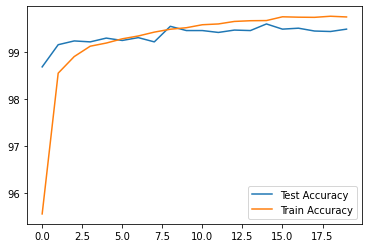

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis = list(range(len(test_acc)))
new_test_acc = [x*100.0 for x in test_acc]

plt.plot(xaxis, new_test_acc, label="Test Accuracy")
plt.plot(xaxis, train_acc, label="Train Accuracy")
plt.legend()
plt.show()